In [1]:
import os
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from keras.callbacks import EarlyStopping

In [2]:
# Ścieżka do folderu z danymi
base_dir = "C:\\Users\\przem\\Desktop\\PWR\\CNN\\xray"

categories = ["NORMAL", "PNEUMONIA"]
img_size = (224, 224)  # Wymiary obrazu
def load_images(data_dir, categories, img_size):
    data = []
    labels = []
    
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)
        
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                # Wczytaj obraz w skali szarości
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                # Przeskaluj do odpowiedniego rozmiaru
                img = cv2.resize(img, img_size)
                # Normalizuj do zakresu [0, 1]
                img = img / 255.0
                # Dodaj wymiar kanału
                img = np.expand_dims(img, axis=-1)
                
                data.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Błąd podczas wczytywania obrazu {img_path}: {e}")
    
    return np.array(data), np.array(labels)

# Wczytanie danych
image_data, image_labels = load_images(base_dir, categories, img_size)
print(f"Shape of data: {image_data.shape}")
print(f"Shape of labels: {image_labels.shape}")


Shape of data: (5856, 224, 224, 1)
Shape of labels: (5856,)


In [3]:
# Podział danych na train i test
image_data_train, image_data_temp, image_labels_train, image_labels_temp = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, stratify=image_labels)

# Podział danych tymczasowych na val i test
image_data_val, image_data_test, image_labels_val, image_labels_test = train_test_split(image_data_temp, image_labels_temp, test_size=0.5, random_state=42, stratify=image_labels_temp)

print(f"Train set: {image_data_train.shape}, Validation set: {image_data_val.shape}, Test set: {image_data_test.shape}")


Train set: (4099, 224, 224, 1), Validation set: (878, 224, 224, 1), Test set: (879, 224, 224, 1)


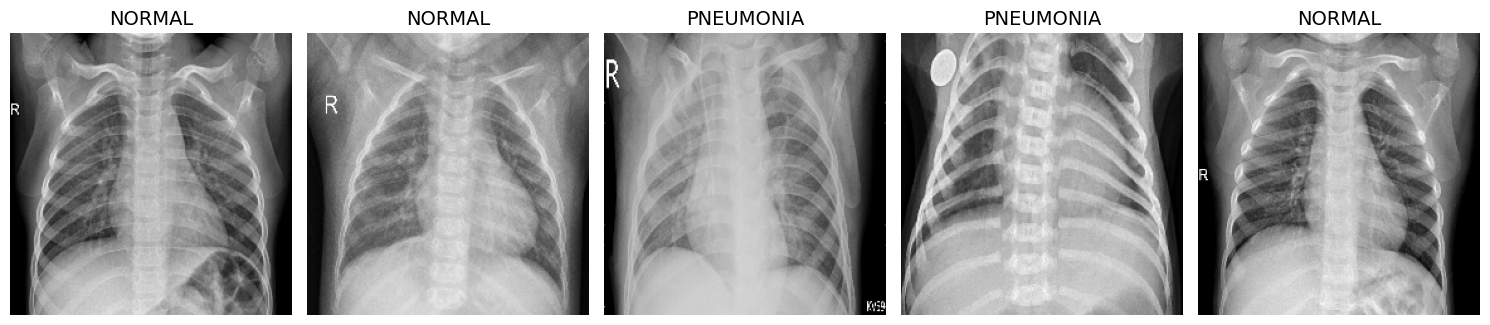

In [4]:
def display_sample_images(images, labels, categories, num_images=5):
    plt.figure(figsize=(15, 5))
    indices = np.random.choice(len(images), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        img = images[idx].squeeze()  # Usuwa wymiar kanału, jeśli istnieje
        label = categories[labels[idx]]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label, fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# Wyświetlanie oryginalnych obrazków
display_sample_images(image_data_train, image_labels_train, categories, num_images=5)



In [5]:
# ImageDataGenerator dla augmentacji danych
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Przygotowanie generatora dla zbioru treningowego
train_generator = datagen.flow(image_data_train, image_labels_train, batch_size=32)

# Normalizacja walidacyjnych i testowych
val_generator = ImageDataGenerator().flow(image_data_val, image_labels_val, batch_size=32)
test_generator = ImageDataGenerator().flow(image_data_test, image_labels_test, batch_size=32)

In [6]:
# Tworzenie tf.data.Dataset
def create_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(image_data_train, image_labels_train)
val_dataset = create_dataset(image_data_val, image_labels_val)
test_dataset = create_dataset(image_data_test, image_labels_test)


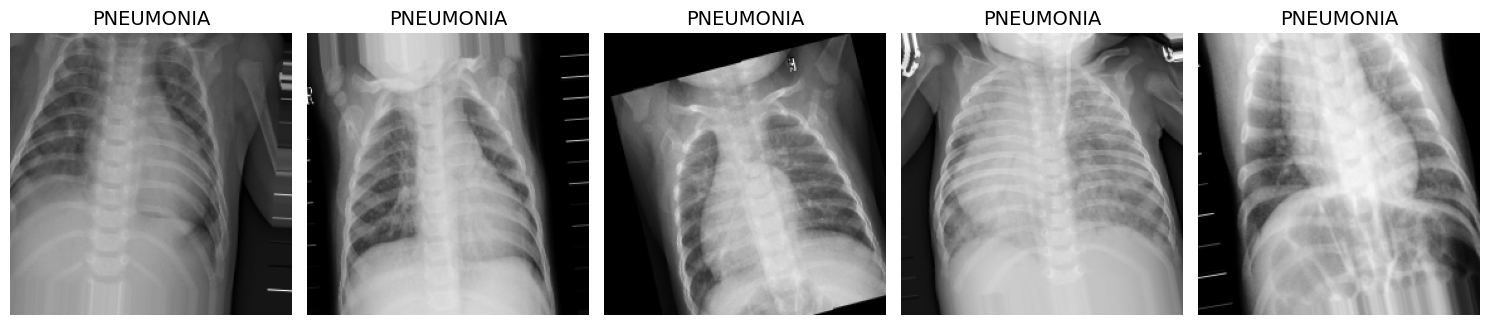

In [7]:
def display_augmented_images(datagen, images, labels, categories, num_images=5):
    plt.figure(figsize=(15, 5))    
    augmented_data = datagen.flow(images, labels, batch_size=num_images)
    augmented_images, augmented_labels = next(augmented_data)
    
    for i in range(num_images):
        img = augmented_images[i].squeeze()  # Usuwa wymiar kanału, jeśli istnieje
        label = categories[int(augmented_labels[i])]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label, fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Wyświetlanie obrazków po augmentacji
display_augmented_images(datagen, image_data_train, image_labels_train, categories, num_images=5)

In [8]:
def create_model():
    model = Sequential([
        Input(shape=(224, 224, 1)),  # Definiowanie kształtu wejściowego za pomocą Input
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Sigmoid dla klasyfikacji binarnej
    ])
    
    return model
    
model = create_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,561,345 (21.21 MB)

 Trainable params: 5,561,345 (21.21 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Tworzenie modelu
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Sprawdzenie poprawności danych w generatorze
for image_data, image_labels in train_dataset.take(1):
    print(f"Shape of features: {image_data.shape}")
    print(f"Shape of labels: {image_labels.shape}")

# Tworzenie obiektu EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=3,                
    restore_best_weights=True  
)

# Trenowanie modelu z wagami klas
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Shape of features: (32, 224, 224, 1)
Shape of labels: (32,)
Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 263ms/step - accuracy: 0.7774 - loss: 0.6274 - val_accuracy: 0.9351 - val_loss: 0.1727
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.9278 - loss: 0.1912 - val_accuracy: 0.9465 - val_loss: 0.1320
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.9443 - loss: 0.1460 - val_accuracy: 0.9499 - val_loss: 0.1416
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.9477 - loss: 0.1317 - val_accuracy: 0.9556 - val_loss: 0.1145
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 33s 259ms/step - accuracy: 0.9580 - loss: 0.1080 - val_accuracy: 0.9556 - val_loss: 0.1391
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - accuracy: 0.9512 - loss: 0.1387 - val_accuracy: 0.9533 - val_loss: 0.1269
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9628 - loss: 0.1023 - val_accuracy: 0.9556 - val_loss: 0.1063
Epoch 8/50
129/129 ━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


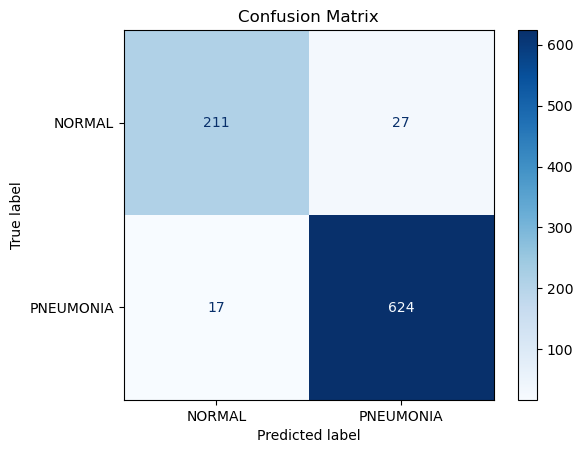

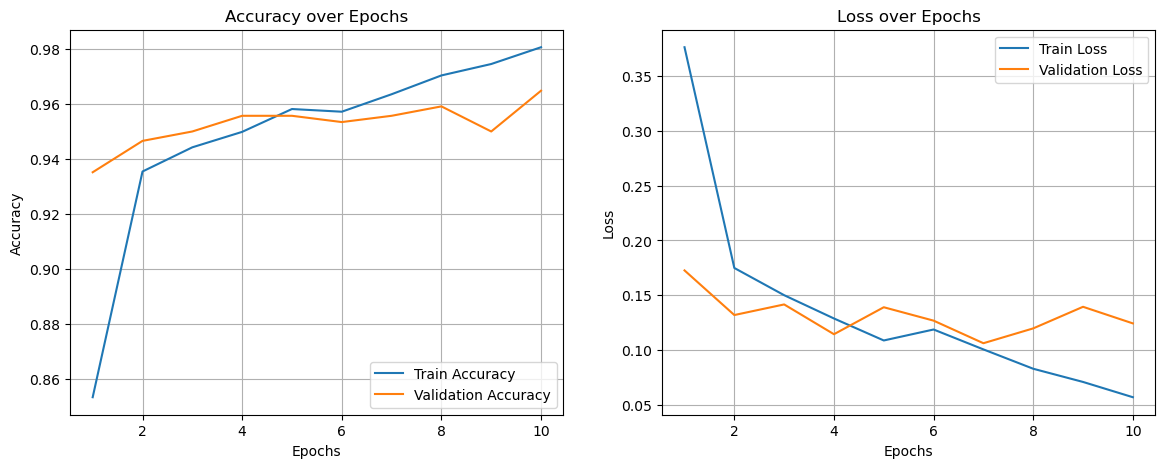

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9455 - loss: 0.1408
Test Accuracy: 0.95
Classification Report:

              precision    recall  f1-score   support

      NORMAL     0.9254    0.8866    0.9056       238
   PNEUMONIA     0.9585    0.9735    0.9659       641

    accuracy                         0.9499       879
   macro avg     0.9420    0.9300    0.9358       879
weighted avg     0.9496    0.9499    0.9496       879

Precision: 0.9254, Recall: 0.8866, F1-score: 0.9056


In [10]:
# Użyj prognoz ciągłych i zaokrąglij je
image_labels_pred = np.round(model.predict(image_data_test)).astype(int)

# Prawdziwe etykiety na zbiorze testowym
image_labels_true = []
for image_data, image_labels in test_dataset:
    image_labels_true.extend(image_labels.numpy())  # Zbieranie prawdziwych etykiet

# Konwersja do numpy array
image_labels_true = np.array(image_labels_test)

# Obliczanie macierzy pomyłek
cm = confusion_matrix(image_labels_test, image_labels_pred)

# Wyświetlanie macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Funkcja do rysowania wykresów
def plot_training_history(history):
    # Wyciągnięcie danych z historii treningu
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)
    
    # Wykres dokładności
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid()

    # Wykres funkcji straty
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid()

    plt.show()

# Wywołanie funkcji do rysowania wykresów
plot_training_history(history)

# Ewaluacja modelu
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Wyświetlanie dodatkowych metryk
report = classification_report(image_labels_true, image_labels_pred, target_names=["NORMAL", "PNEUMONIA"], digits=4)
print("Classification Report:\n")
print(report)

# Dodatkowe metryki
precision = report.split('\n')[2].split()[1]
recall = report.split('\n')[2].split()[2]
f1 = report.split('\n')[2].split()[3]
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")
